# 0.2 Running a Basic Model on Combigen

In this notebook we're going to just run the combigen task designed in nb 0.1 on some more modern models.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Mon Feb 18 2019 20:32:44 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
matplotlib 3.0.2
seaborn 0.9.0
tensorflow 1.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 9e066d8690c6a5afc03915dc3eaf756cda317f85
Git branch : resnet


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cbg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cbhm
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging

## Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [19]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger()

## The Combigen Task

Now that the task has been put together from nb 0.1, let's import the functionified version of it and start prepping for running the model.

First let's refresh our memory on the task.

2019-02-18 20:32:51 apra-xps13 leabratf.utils[3514] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.
2019-02-18 20:32:51 apra-xps13 leabratf.utils[3514] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.


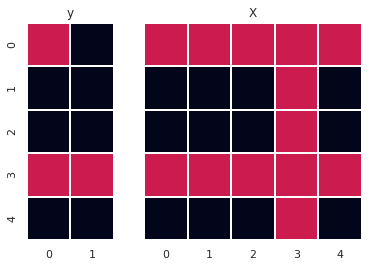

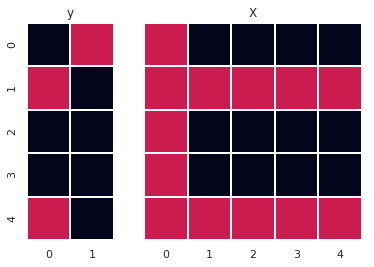

In [8]:
cbhm.visualize_combigen(2)
plt.show()

Now that it works as expected, lets move back to setting up the data.

## O'Reily BP Model

Before working with anything close to state of the art (SOTA), a good place to start is with the backpropagation model that O'Reily used in his paper. It's described as a fully connected network with 100 hidden units, so let's put all that into a hyper-parameter variable.

Note: Instead of dictionaries to hold config-type data, I'm using `pdict`s from the [pstar](https://github.com/iansf/pstar) repo as mentioned in [this](https://danijar.com/patterns-for-fast-prototyping-with-tensorflow/) blog post.

In [9]:
# pdicts allow for attribute dictionary setting among other things
from pstar import pdict
# for the checkpoint path
from leabratf.constants import DIR_MODELS

hyper_params = pdict()

# Task parameters - see the 0.1 for the experimental design
hyper_params.combigen_dims = 2
hyper_params.combigen_size = 5
# Stack number is currently not implemented, but will be for future analyses
# hyper_params.combigen_stack = 4
hyper_params.n_train = 100
hyper_params.n_test = 10000

# Network parameters - see paper description
hyper_params.layer_size = 100
hyper_params.output_size = hyper_params[['combigen_size', 'combigen_dims']]

# Training parameters
hyper_params.learning_rate = 0.001
hyper_params.batch_size = 1 
hyper_params.epochs = 100

# Experiment Parameters
hyper_params.save_weights = True
hyper_params.validation_iters = 1000

hyper_params.checkpoint_path = str(DIR_MODELS / 'checkpoints')

Let's put together the dataset object that will be fed into the model. First generate the master list of data to be used for training and testing.

In [10]:
y = cbg.generate_labels(
    n_samples = hyper_params.n_train + hyper_params.n_test,
    size = hyper_params['combigen_size'],
    dims = hyper_params['combigen_dims'])
X = cbg.inverse_transform(y)
# Quick sanity check
assert X.shape[0] == y.shape[0]

# Lets print some quick info
print('Shape y: {0} \nShape X: {1}'.format(y.shape, X.shape))

Shape y: (10100, 5, 2) 
Shape X: (10100, 5, 5)


And then let's put it in a `dataset` object.

In [11]:
# Define the input fn
def input_fn(mode, params):
    n_samples = params.n_train if mode==tf.estimator.ModeKeys.EVAL else params.n_test
    
    y = cbg.generate_labels(n_samples=n_samples,
                            size=params['combigen_size'],
                            dims=params['combigen_dims'])
    X = cbg.inverse_transform(y)
    # Quick sanity check
    assert X.shape[0] == y.shape[0]

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.batch(params['batch_size'])
    return dataset

Now we can start putting together the model.

In [12]:
def create_model_obp(input_tensor, mode, hyper_params):
    """Function that generates the the O'Reily backpropagation model."""
    model = pdict()
    with tf.variable_scope("OBPDenseNet") as scope:
        # Reuse the weights if we're evaling
        if mode == tf.estimator.ModeKeys.EVAL:
            scope.reuse_variables()
        # Reshape the data accordingly
        x = tf.reshape(tensor=input_tensor, shape=[-1, *hyper_params['output_size']], name='input')
        # Single hidden layer
        model.logits = tf.layers.dense(x, units=hyper_params['layer_size'])
        model.probs = tf.nn.softmax(logits=model.logits, name='probs')
    return model

Next the loss.

In [16]:
def create_loss(model, labels, mode, hyper_params):
    """Function that returns the loss of a model on the labels."""
    metrics = pdict()
    
    y = tf.reshape(labels, [-1, *hyper_params['output_size']], name='labels')
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=model.logits,
        labels=y,
    ))
    loss_name = str(mode) + '/loss'
    tf.summary.scalar(loss_name, loss_op)
    metrics.loss_name = loss_op
    
    return loss_op, metrics

Now put them together along with an optimizer to create `model_fn`

In [17]:
def model_fn(features, labels, mode, params):
    # Create the model
    model = create_model_obp(features, mode, params)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=model)
    
    # Create the loss operation
    loss, metrics = create_loss(model, labels, mode, params)
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    # Define the optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        with tf.variable_scope("optimizer"):
            # Define a training operation
            train_op = tf.train.GradientDescentOptimizer(
                learning_rate=params['learning_rate']).minimize(loss)
            return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    
    raise RuntimeError('Invalid mode entered, {})'.format(mode))

In [20]:

config = tf.estimator.RunConfig()
estimator = tf.estimator.Estimator(model_fn, params=hyper_params)

train_spec = tf.estimator.TrainSpec(input_fn=lambda:input_fn(tf.estimator.ModeKeys.TRAIN, hyper_params))
eval_spec = tf.estimator.EvalSpec(input_fn=lambda:input_fn(tf.estimator.ModeKeys.EVAL, hyper_params))

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using default config.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Using default config.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] WARNING Using temporary folder as model directory: /tmp/tmpduqp2a1d


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpduqp2a1d', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff2a85b9080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Using config: {'_model_dir': '/tmp/tmpduqp2a1d', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff2a85b9080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Running training and evaluation locally (non-distributed).


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Calling model_fn.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Calling model_fn.


INFO:tensorflow:Done calling model_fn.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Graph was finalized.


INFO:tensorflow:Running local_init_op.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2019-02-18 20:39:34 apra-xps13 tensorflow[3514] INFO Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpduqp2a1d/model.ckpt.


2019-02-18 20:39:35 apra-xps13 tensorflow[3514] INFO Saving checkpoints for 0 into /tmp/tmpduqp2a1d/model.ckpt.


InvalidArgumentError: Input to reshape is a tensor with 25 values, but the requested shape requires a multiple of 10
	 [[Node: OBPDenseNet/input = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorGetNext, labels/shape)]]

Caused by op 'OBPDenseNet/input', defined at:
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2c2e39843215>", line 8, in <module>
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/estimator/training.py", line 451, in train_and_evaluate
    return executor.run()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/estimator/training.py", line 590, in run
    return self.run_local()
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/estimator/training.py", line 691, in run_local
    saving_listeners=saving_listeners)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 376, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1145, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1170, in _train_model_default
    features, labels, model_fn_lib.ModeKeys.TRAIN, self.config)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1133, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-17-b3f96322f167>", line 3, in model_fn
    model = create_model_obp(features, mode, params)
  File "<ipython-input-12-8c80f3711f2b>", line 9, in create_model_obp
    x = tf.reshape(tensor=input_tensor, shape=[-1, *hyper_params['output_size']], name='input')
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6199, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/apra/miniconda3/envs/leabratf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 25 values, but the requested shape requires a multiple of 10
	 [[Node: OBPDenseNet/input = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorGetNext, labels/shape)]]


In [ ]:
hyper_params.output_size

In [ ]:
hyper_params.output_size


So let's just confirm that `tensorflow` is happy with the function.

## Hints

Various hints for working on `jupyter notebooks`. Should probably be removed when a notebook is completed.

General stuff:
- To make logging even lazier, set `print = logger.info`, and then `print` away!
- The `!` can be used to run shell commands from within the notebook (ex. `!which conda`)
- Use `assert` liberally - this isn't a script and it's very readable.

Cheatsheets:
- [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)